Добавим все необходимые импорты


In [1]:
import os
from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import numpy as np

import pickle
import joblib


In [2]:
# Для начала работы подключимся к папке, в которой хранятся все тексты.

drive.mount('/content/drive')
storage = '/content/drive/MyDrive/Colab Notebooks/Корпус текстов'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Так как моего датасета в 200 текстов было слишком мало, для начала я решила хотя бы немного его увеличить с помощью подключения к API Gigachat и промпта, по которому нейросеть могла бы точнее выполнить мою задачу

In [ ]:
! pip install langchain-gigachat langchain-community sentence-transformers langchain-huggingface chromadb langchain-chroma

In [4]:
api_key = "MDE5YzRjMzYtMjVkZi03YmQyLWI4Y2ItMzJiZmZmZTY1ZDU0OmM5NWI5ZGQ0LTljZGItNDhjNS04NzYwLWJjNzhmYWVmMWJjMA=="

In [5]:
from langchain_gigachat.chat_models.gigachat import GigaChat

In [6]:
from langchain_core.messages import HumanMessage, SystemMessage

In [7]:
model = GigaChat(
    #model="GigaChat-Pro",
    model="GigaChat-Max",
    credentials=api_key.strip(),
    verify_ssl_certs=False,
)

In [ ]:
# Для написания промпта воспользовалась подсказкой ИИ и брала информацию с разных сайтов.

messages = [
    SystemMessage(
        content="""Ты — экспертный помощник преподавателя английского языка.
Твоя задача — создать учебный текст строго по спецификации CEFR.

Уровень: [A1/A2/B1/B2/C1]
Тема: [например: my pet, travelling, technology, environment]
Объём: [например: 40-60 слов / 70-90 слов / 100-130 слов / 150-200 слов / 200-250 слов]

Грамматические требования для этого уровня:

A1:
- Грамматика: to be; личные и притяжательные местоимения; a/an, (базово) the; множественное число существительных;
  this/that/these/those; ’s (притяжательный); have got; there is/are; Present Simple (+/−/?), наречия частоты;
  Present Continuous (в основе); императив; some/any; исчисляемые/неисчисляемые (базово), much/many;
  предлоги места/времени (in/on/at); простые вопросительные слова (who/what/where/when/how much/many);
  Past Simple (was/were, только самые частотные неправильные глаголы); Past Continuous; Future Simple
- Модальный глагол: can/can't; would like
- Конструкции: there is/are; like + -ing
- Предложения максимум 15-20 слов, не делай предложения слишком маленькими!
- Союзы: and; but; because
- Используй простую лексику

A2:
- Времена: Present Simple, Past Simple, Future Simple (will), Будущее время с использованием "going to" — для предсказаний, обещаний и планов
- Модальные глаголы: can, could, must, should, have to
- Конструкции: like + -ing, want to
- Союзы: and, but, because
- Сравнительные и превосходные степени прилагательных
- Предлоги времени и места
- Порядковые числительные


B1:
- Времена: Present Perfect, Past Continuous, все простые времена
- Модальные глаголы: might, could, have to
- Конструкции: Conditional 1 (if + will)
- Придаточные предложения с when, if, although
- Пассив: is made, are found


B2:
- Времена: Past Perfect, Future Continuous
- Модальные глаголы: needn't, ought to
- Конструкции: Conditional 2 (if + would)
- Пассив в разных временах
- Герундий vs инфинитив
- Инверсия после отрицательных наречий

C1:
- Времена: Future Perfect, Future Perfect Continuous
- Модальные глаголы: would rather, had better
- Конструкции: Conditional 3, mixed conditionals
- Complex subject (he is said to be)
- Инверсия, cleft sentences
- Идиомы и тонкие смысловые оттенки

ВАЖНО:
1. Текст должен строго соответствовать грамматическим требованиям уровня
2. Тема должна быть exactly "[тема]"
3. Объём: точно [объём] слов
4. Не добавляй пояснений от себя, только текст
5. Только на английском языке

Напиши текст."""
    )
]

while(True):
    user_input = input("Пользователь: ")
    if user_input == "пока":
      break
    messages.append(HumanMessage(content=user_input))
    res = model.invoke(messages)
    messages.append(res)
    print("GigaChat: ", res.content)

С помощью нейросети удалось добавить еще 50 текстов (и токены закончились).
Затем я добавила еще 100 текстов уже путем функции распознавания текста в PDF- версиях книг, одобренных центрами для сдачи CEFR экзаменов (New English File, Upstream, Enterprise, Macmillan и так далее).
В итоге получилось 350 текстов.

Для решения проблемы недостаточности данных, я воспользовалась таким методом аугментации данных, как обратный перевод. Я взяла модель с сайта HuggingFace для перевода текстов с английского на немецкий и обратно.

In [ ]:
# Загрузим модели для перевода с английского на немецкий и с немецкого на английский с Hugging Face (https://huggingface.co/Helsinki-NLP/opus-mt-en-de + https://huggingface.co/Helsinki-NLP/opus-mt-de-en )

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer_en_de = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")

model_en_de = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-de")

tokenizer_de_en = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-de-en")

model_de_en = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-de-en")

In [6]:
# Путем проб и ошибок выяснила, что для успешной аугментации текстов лучше работать с предложениями, а не отдельными словами. Для этого воспользуемся библиотекой nltk.

nltk.download('punkt_tab')

from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
# Создадим путь, по которому будут сохраняться новые аугментированные тексты.

augment_storage = '/content/drive/MyDrive/Colab Notebooks/Корпус текстов augmented'

In [4]:
# Создадим функцию, которая проходится по текстам в папке каждого уровня от A1 до C1 и собирает списки из текстов.

levels = ['A1', 'A2', 'B1', 'B2', 'C1']

def texts_bylevels():
    path = storage
    result = []

    for level in levels:
        folder_path = os.path.join(path, level)
        texts = []

        # Получаем список файлов
        files = os.listdir(folder_path)

        # Установим правильную сортировку
        def get_number(filename):
            try:
                number_part = filename.split('.')[1].split('.')[0]
                return int(number_part)
            except:
                return 0

        files_sorted = sorted(files, key=get_number)

        for file_name in files_sorted:
            full_path = os.path.join(folder_path, file_name)
            with open(full_path, 'r', encoding='utf-8') as file:
                texts.append(file.read())

        result.append(texts)


    return result

In [ ]:
# Сформулируем функцию перевода с английского на немецкий.

def translation(text, model, tokenizer, target_tokenizer=None, max_length=400):

    inputs = tokenizer(text, return_tensors="pt",
                      padding=True,
                      truncation=True,
                      max_length=max_length)

    with torch.no_grad():
        translated_ids = model.generate(
            **inputs,
            max_length=max_length,
            do_sample=True,
            temperature=0.7,
            num_beams=1,
            early_stopping=True
        )

    # Проверка токенов для следующей модели.

    if target_tokenizer is not None:
        vocab_size = target_tokenizer.vocab_size
        if translated_ids.max().item() >= vocab_size:
            safe_ids = translated_ids.clone()
            safe_ids[safe_ids >= vocab_size] = target_tokenizer.unk_token_id
            translated_ids = safe_ids

    return tokenizer.decode(translated_ids[0], skip_special_tokens=True)


In [ ]:
# Функция для обратного перевода.

def back_translation(text):
  sentences = sent_tokenize(text)
  translated = []


  for i, sent in enumerate(sentences):
    german = translation(sent, model_en_de, tokenizer_en_de)
    back = translation(german, model_de_en, tokenizer_de_en)
    translated.append(back)


  return ' '.join(translated)

In [ ]:
# Собираем исходные тексты.

texts_by_level = texts_bylevels()

In [ ]:
# Приступим к аугментации текстов.

total = 0
copies = 3
errors = []

for i in range(len(levels)):
    level = levels[i]
    texts = texts_by_level[i]

    for j in range(len(texts)):
        text = texts[j]

        for k in range(copies):
            new = back_translation(text)

            # Сохраняем.

            name = f"{level}_{j+1}_copy_{k+1}.txt"
            path = os.path.join(augment_storage, level, name)

            with open(path, 'w', encoding='utf-8') as f:
                f.write(new)

            total += 1

        print()

Таким образом, у меня получился датасет уже из 1400 текстов. Следующим шагом попробуем кодирование текстовой информации с помощью TF-IDF Vectorizer.

In [5]:
# Функция, которая собирает уже аугментированные тексты

def texts_bylevels_augment():
    path = augment_storage
    result = []

    for level in levels:
        folder_path = os.path.join(path, level)
        texts = []

        # Получаем список файлов
        files = os.listdir(folder_path)

        # Установим правильную сортировку
        def get_number(filename):
            try:
                number_part = filename.split('.')[1].split('.')[0]
                return int(number_part)
            except:
                return 0

        files_sorted = sorted(files, key=get_number)

        for file_name in files_sorted:
            full_path = os.path.join(folder_path, file_name)
            with open(full_path, 'r', encoding='utf-8') as file:
                texts.append(file.read())

        result.append(texts)


    return result

In [6]:
# Получим все 1400 текстов

texts_by_level_augment = texts_bylevels_augment()

In [7]:
# Преобразуем собранные тексты в структуру : текст - соответствующая метка (уровень).

all_texts = []
all_labels = []

levels = ['A1', 'A2', 'B1', 'B2', 'C1']

result = texts_bylevels_augment()

for i, level in enumerate(levels):
     for text in result[i]:
          all_texts.append(text)
          all_labels.append(level)

In [10]:
# Разделим тексты на тренировочные и тестовые.

X_train, X_test, y_train, y_test = train_test_split(all_texts, all_labels,
                                                     test_size=0.2,
                                                     random_state=42,
                                                     stratify=all_labels)

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# Закодируем тексты с помощью векторайзера tf-idf.
# Настроим векторайзер.

tf_idf = TfidfVectorizer(stop_words='english',
                         min_df=2,             # Игнорируем слишком редкие слова
                         max_features=5000,
                         ngram_range=(1, 3))

In [13]:
# Обучаем векторайзер на тренировочных данных.

tf_idf.fit(X_train)

TfidfVectorizer(max_features=5000, min_df=2, ngram_range=(1, 3),
                stop_words='english')

In [14]:
# Закодируем тексты с помощью tf-idf.

X_train_tfidf = tf_idf.transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

In [15]:
# Проверка размерности данных.

X_train_tfidf.shape

(1120, 5000)

По совету преподавателя воспользовалась CatBoost, для оптимизации работы с категориальными данными.

In [ ]:
!pip install catboost

In [16]:
from catboost import CatBoostClassifier

In [17]:
# Catboost использует специальный объект Pool для представления данных (в моем случае нужен именно он,
# так как матрица TF-IDF разреженная).

from catboost import Pool

In [18]:
train_data = Pool(data=X_train_tfidf, label=y_train)

In [19]:
# Создаем экземпляр модели для классификации.

catboost_tfidf = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=6)
catboost_tfidf.fit(train_data,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.5826294	total: 1.38s	remaining: 22m 57s
1:	learn: 1.5607557	total: 1.9s	remaining: 15m 47s
2:	learn: 1.5428428	total: 2.44s	remaining: 13m 30s
3:	learn: 1.5212348	total: 2.97s	remaining: 12m 19s
4:	learn: 1.5041140	total: 3.5s	remaining: 11m 37s
5:	learn: 1.4880735	total: 4.03s	remaining: 11m 7s
6:	learn: 1.4749811	total: 4.57s	remaining: 10m 48s
7:	learn: 1.4559461	total: 5.15s	remaining: 10m 38s
8:	learn: 1.4394346	total: 6.01s	remaining: 11m 2s
9:	learn: 1.4222829	total: 6.9s	remaining: 11m 22s
10:	learn: 1.4108053	total: 7.72s	remaining: 11m 34s
11:	learn: 1.3940883	total: 8.66s	remaining: 11m 53s
12:	learn: 1.3722482	total: 9.48s	remaining: 12m
13:	learn: 1.3580997	total: 10.3s	remaining: 12m 5s
14:	learn: 1.3403532	total: 10.9s	remaining: 11m 53s
15:	learn: 1.3267161	total: 11.4s	remaining: 11m 41s
16:	learn: 1.3146404	total: 11.9s	remaining: 11m 30s
17:	learn: 1.3016528	total: 12.5s	remaining: 11m 20s
18:	learn: 1.2900471	total: 13s	remaining: 11m 11s
19:	learn: 1.27

CatBoostClassifier(depth=6, iterations=1000, learning_rate=0.1)

In [35]:
# Сохраняем модель.

joblib.dump(catboost_tfidf, '/content/drive/MyDrive/Colab Notebooks/catboost_tfidf_model.joblib')

['/content/drive/MyDrive/Colab Notebooks/catboost_tfidf_model.joblib']

In [20]:
# Оценим производительность обученной модели на тестовых данных.

test_data = Pool(X_test_tfidf, y_test)
accuracy = catboost_tfidf.score(test_data)
accuracy

np.float64(0.9678571428571429)

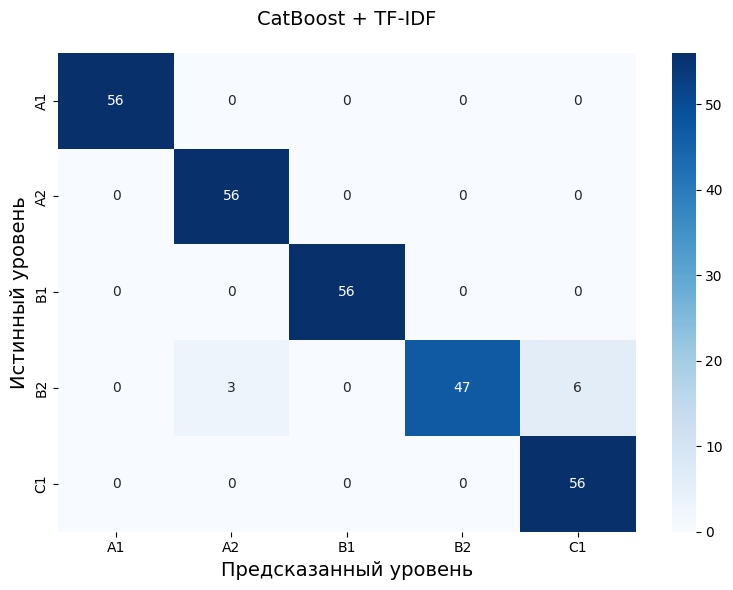

In [36]:
# Визуализация результатов с помощью матрицы путаницы

y_pred = catboost_tfidf.predict(X_test_tfidf)
cm_tfidf= confusion_matrix(y_test, y_pred, labels = levels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=levels,
            yticklabels=levels)

plt.title('CatBoost + TF-IDF', fontsize=14, pad=20)
plt.xlabel('Предсказанный уровень', fontsize=14)
plt.ylabel('Истинный уровень', fontsize=14)
plt.tight_layout()
plt.show()

Для оптимизации ситуации я воспользовалась способом кодирования текстов с помощью предложенной преподавателем модели BERT,обученной на базе трансформера.

In [24]:
from transformers import BertTokenizer, BertModel

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

In [26]:
# Применим предобученную модель Bert к тренировочным данным

# Напишем функцию для получения эмбеддингов:

def get_embeddings(texts):
    embeddings = []

    for i, text in enumerate(texts):
        encoded_input = tokenizer(text,
                                  return_tensors='pt',
                                  truncation=True,
                                  max_length=128)



        # так как Bert уже предобучен, в вычислении градиента нет необходимости.

        with torch.no_grad():
            output = model(**encoded_input)
            cls_embedding = output.last_hidden_state[0, 0, :].numpy()  # [CLS] маркер используется для агрегации контекстной информации всего текста.
            embeddings.append(cls_embedding)

    # Преобразуем в numpy массив для дальнейшей работы с CatBoost.

    return np.array(embeddings)


In [27]:
# Получаем эмбеддинги для тренировочных и тестовых данных.

X_train_bert = get_embeddings(X_train)
X_test_bert = get_embeddings(X_test)

In [37]:
# Сохраним эмбеддинги.

np.save('/content/drive/MyDrive/Colab Notebooks/bert_embeddings_train.npy', X_train_bert)
np.save('/content/drive/MyDrive/Colab Notebooks/bert_embeddings_test.npy', X_test_bert)

In [28]:
X_train_bert

array([[ 0.02315869,  0.06515092, -0.12963225, ..., -0.13146009,
         0.7023931 ,  0.38443524],
       [-0.2991272 , -0.13127618,  0.14668494, ..., -0.21176937,
         0.72199005, -0.06717053],
       [-0.1431693 , -0.13563073,  0.5183906 , ..., -0.6120451 ,
         0.844818  ,  0.28620484],
       ...,
       [-0.28011334, -0.15703565,  0.14634016, ..., -0.16329531,
         1.0137    ,  0.09803803],
       [-0.28724453, -0.0619022 , -0.07195623, ..., -0.09413414,
         0.07912689,  0.58849233],
       [ 0.09244864,  0.23530415,  0.4071586 , ..., -0.16780387,
         0.44896132,  0.8280924 ]], dtype=float32)

In [29]:
# Перейдем к реализации модели CatBoost уже на эмбеддингах.

catboost_bert = CatBoostClassifier(iterations=200,
                           learning_rate=0.1,
                           depth=6,
                           early_stopping_rounds=50,
                           random_seed=42)

catboost_bert.fit(X_train_bert, y_train)

0:	learn: 1.5532614	total: 3.36s	remaining: 11m 8s
1:	learn: 1.4915441	total: 4.63s	remaining: 7m 38s
2:	learn: 1.4420128	total: 5.88s	remaining: 6m 26s
3:	learn: 1.3929588	total: 6.92s	remaining: 5m 39s
4:	learn: 1.3474490	total: 7.65s	remaining: 4m 58s
5:	learn: 1.3072988	total: 8.42s	remaining: 4m 32s
6:	learn: 1.2727501	total: 9.17s	remaining: 4m 12s
7:	learn: 1.2429885	total: 9.9s	remaining: 3m 57s
8:	learn: 1.2140898	total: 10.7s	remaining: 3m 46s
9:	learn: 1.1773774	total: 11.5s	remaining: 3m 37s
10:	learn: 1.1442512	total: 12.2s	remaining: 3m 30s
11:	learn: 1.1178150	total: 13s	remaining: 3m 22s
12:	learn: 1.0895801	total: 13.7s	remaining: 3m 17s
13:	learn: 1.0630921	total: 14.5s	remaining: 3m 12s
14:	learn: 1.0403914	total: 15.2s	remaining: 3m 7s
15:	learn: 1.0199218	total: 16s	remaining: 3m 3s
16:	learn: 0.9952415	total: 16.8s	remaining: 3m
17:	learn: 0.9774590	total: 18s	remaining: 3m 2s
18:	learn: 0.9575874	total: 19.3s	remaining: 3m 3s
19:	learn: 0.9397152	total: 20.6s	rem

CatBoostClassifier(depth=6, early_stopping_rounds=50, iterations=200, learning_rate=0.1, random_seed=42)

In [38]:
# Сохраняем модель.

joblib.dump(catboost_bert, '/content/drive/MyDrive/Colab Notebooks/catboost_bert_model.joblib')

['/content/drive/MyDrive/Colab Notebooks/catboost_bert_model.joblib']

In [30]:
# Оценим производительность обученной модели на тестовых данных.

accuracy = catboost_bert.score(X_test_bert, y_test)
accuracy

np.float64(0.8642857142857143)

In [31]:
# Посмотрим более подробный отчет.

y_pred = catboost_bert.predict(X_test_bert)
print(classification_report(y_test, y_pred,
                           target_names=levels))

              precision    recall  f1-score   support

          A1       0.89      0.91      0.90        56
          A2       0.90      0.82      0.86        56
          B1       0.84      0.91      0.87        56
          B2       0.85      0.80      0.83        56
          C1       0.84      0.88      0.86        56

    accuracy                           0.86       280
   macro avg       0.87      0.86      0.86       280
weighted avg       0.87      0.86      0.86       280



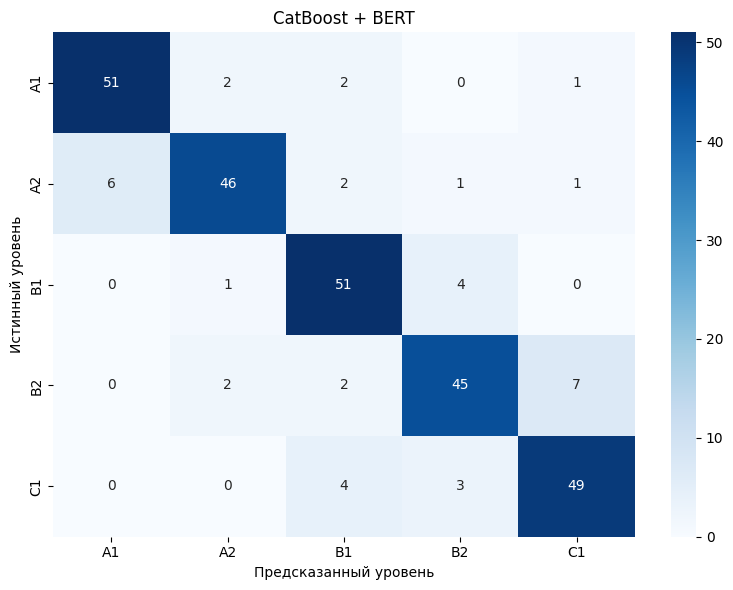

In [33]:
# Посмотрим на матрицу ошибок
cm_bert = confusion_matrix(y_test, y_pred, labels=levels)

# Визуализация
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues',
            xticklabels=levels,
            yticklabels=levels)
plt.title(f'CatBoost + BERT')
plt.ylabel('Истинный уровень')
plt.xlabel('Предсказанный уровень')
plt.tight_layout()
plt.show()

Я сравнила два способа подготовки текстов для определения их уровня сложности:
1) Векторизация с помощью TF-IDF (то есть было подсчитано, какие слова чаще всего встречаются в текстах каждого уровня)
2) Кодировка текстов в эмбеддинги с помощью предобученой модели BERT (она хорошо умеет анализировать контексты)

Эти подготовленные наборы данных я подала в CatBoost. Результаты:

1) TF-IDF + CatBoost показал 96.8% точности. Результат очень высокий, соответственно, подозрительный.
2) BERT + CatBoost показал 86% точности.
A1, B1, C1 определяются хорошо (88-91% точности).
A2 иногда путается с A1 (тексты на границе уровней).
B2 оказался самым сложным, так как это "переходный" уровень: часть текстов уже тянется к C1, часть еще похожа на B1.

TF-IDF показал завышенный результат (96.8%), потому что нашел поверхностные закономерности: длину текстов, частотность определенных слов, структуру предложений. Модель определяла уровень по внешним признакам, а не по реальной сложности текста. BERT же, благодаря пониманию контекста, выдал реалистичную оценку в 86%, которую можно считать настоящей точностью классификации.